In [ ]:
!git clone https://github.com/tareknaous/readme.git

Cloning into 'readme'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 71 (delta 14), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (71/71), 1.96 MiB | 34.52 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
import torch
from tqdm.notebook import tqdm

#from transformers import BertTokenizer
from transformers import XLMRobertaTokenizer
from torch.utils.data import TensorDataset

#from transformers import BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification
import pandas as pd
import numpy as np

In [ ]:
language = 'en'
data_train = pd.concat([pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_train.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_val.xlsx')], axis=0)
data_val = pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_test.xlsx')

In [ ]:
n_labels = len(np.unique(data_train['Rating']))
label_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

for label in np.unique(data_train['Rating']):
    label_dict[label] = label-1

In [ ]:
train = pd.DataFrame(columns=['text', 'label'])
train['text'] = data_train['Sentence']
train['label'] = data_train['Rating'].replace(label_dict)

val = pd.DataFrame(columns=['text', 'label'])
val['text'] = data_val['Sentence']
val['label'] = data_val['Rating'].replace(label_dict)

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    train['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train['label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base',
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 20

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr=2e-6,
                  eps=1e-8)

epochs = 100

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.7294949546573668
Validation loss: 1.624751591682434
F1 Score (macro): 0.07906558849955075


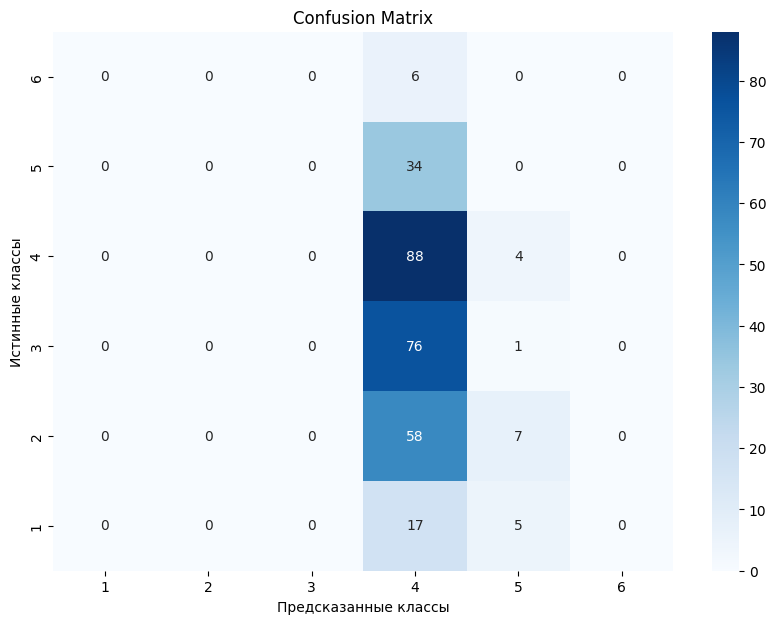

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 0/65 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 3
Accuracy: 0/77 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 4
Accuracy: 88/92 (True Positives / Total Actual Positives)
Precision: 0.32
Recall: 0.96
F1 Score: 0.47

Class: 5
Accuracy: 0/34 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 2:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.5783580982778955
Validation loss: 1.4603699445724487
F1 Score (macro): 0.18047967479674798


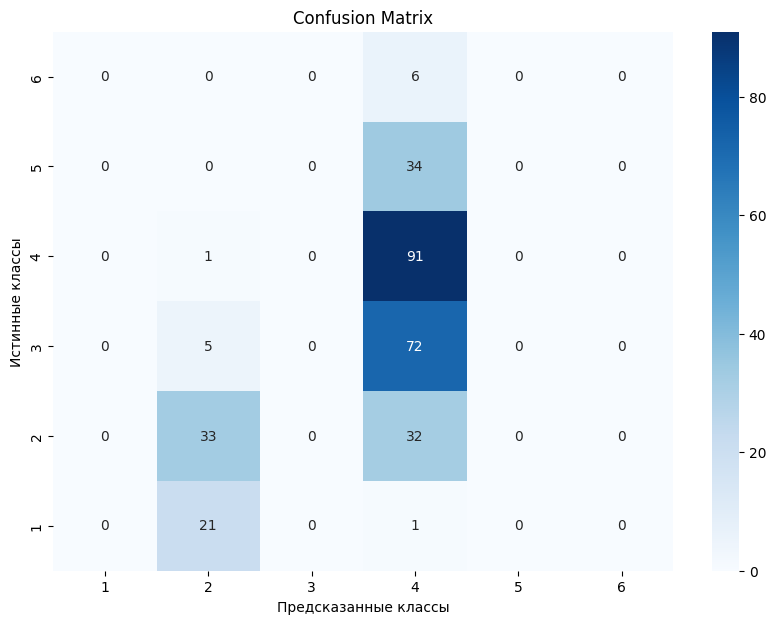

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 33/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.51
F1 Score: 0.53

Class: 3
Accuracy: 0/77 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 4
Accuracy: 91/92 (True Positives / Total Actual Positives)
Precision: 0.39
Recall: 0.99
F1 Score: 0.55

Class: 5
Accuracy: 0/34 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 3:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.432646568365923
Validation loss: 1.2907073815663657
F1 Score (macro): 0.20976896389782027


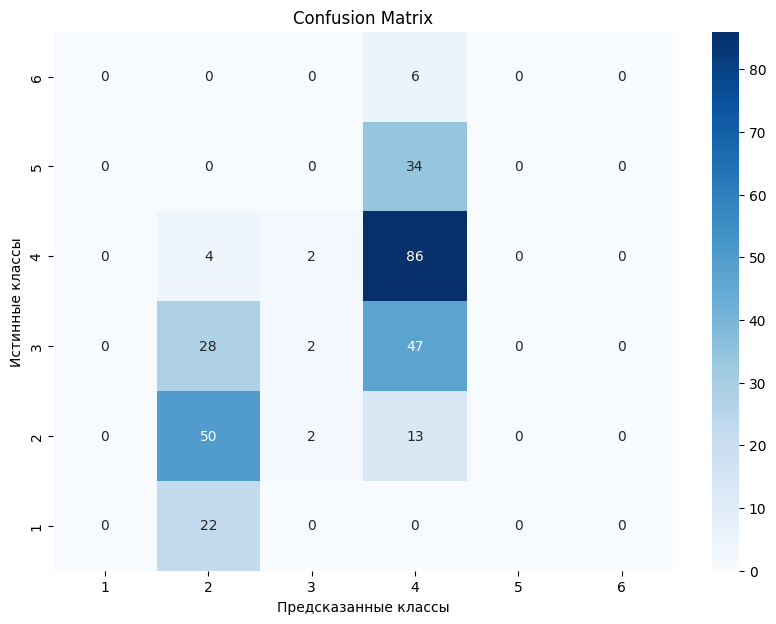

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 50/65 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.77
F1 Score: 0.59

Class: 3
Accuracy: 2/77 (True Positives / Total Actual Positives)
Precision: 0.33
Recall: 0.03
F1 Score: 0.05

Class: 4
Accuracy: 86/92 (True Positives / Total Actual Positives)
Precision: 0.46
Recall: 0.93
F1 Score: 0.62

Class: 5
Accuracy: 0/34 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 4:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.3056931448733713
Validation loss: 1.183199405670166
F1 Score (macro): 0.2592304910272433


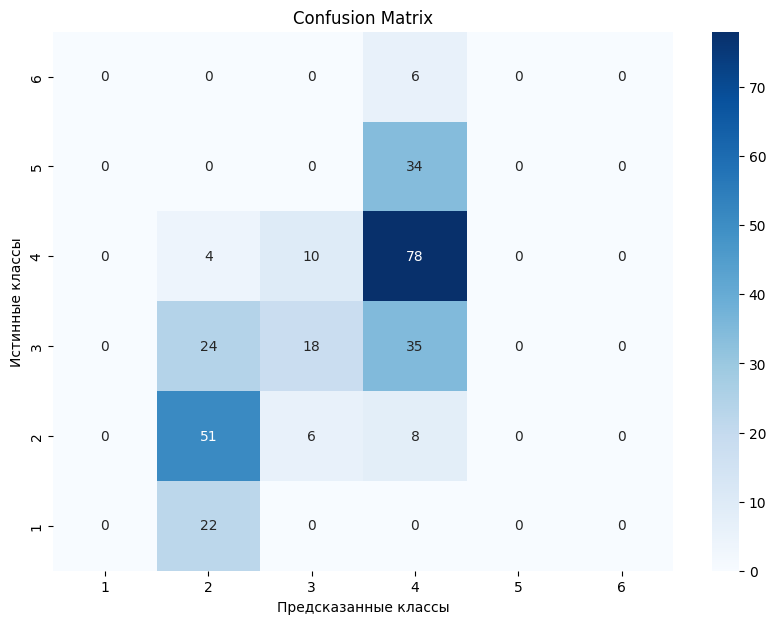

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 51/65 (True Positives / Total Actual Positives)
Precision: 0.50
Recall: 0.78
F1 Score: 0.61

Class: 3
Accuracy: 18/77 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.23
F1 Score: 0.32

Class: 4
Accuracy: 78/92 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.85
F1 Score: 0.62

Class: 5
Accuracy: 0/34 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 5:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.2256904985961012
Validation loss: 1.1170010924339295
F1 Score (macro): 0.31254501353306613


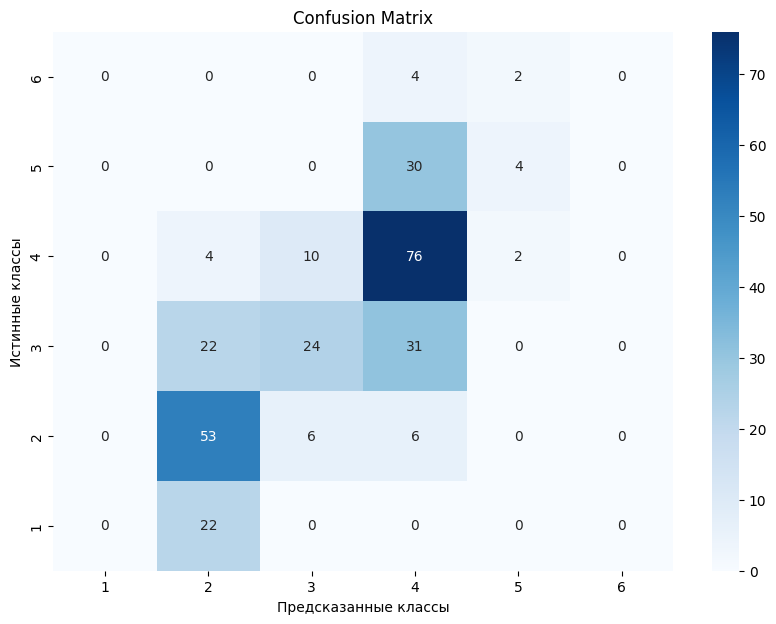

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 53/65 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.82
F1 Score: 0.64

Class: 3
Accuracy: 24/77 (True Positives / Total Actual Positives)
Precision: 0.60
Recall: 0.31
F1 Score: 0.41

Class: 4
Accuracy: 76/92 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.83
F1 Score: 0.64

Class: 5
Accuracy: 4/34 (True Positives / Total Actual Positives)
Precision: 0.50
Recall: 0.12
F1 Score: 0.19

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 6:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.1640819921268253
Validation loss: 1.0696623563766479
F1 Score (macro): 0.33884796216154517


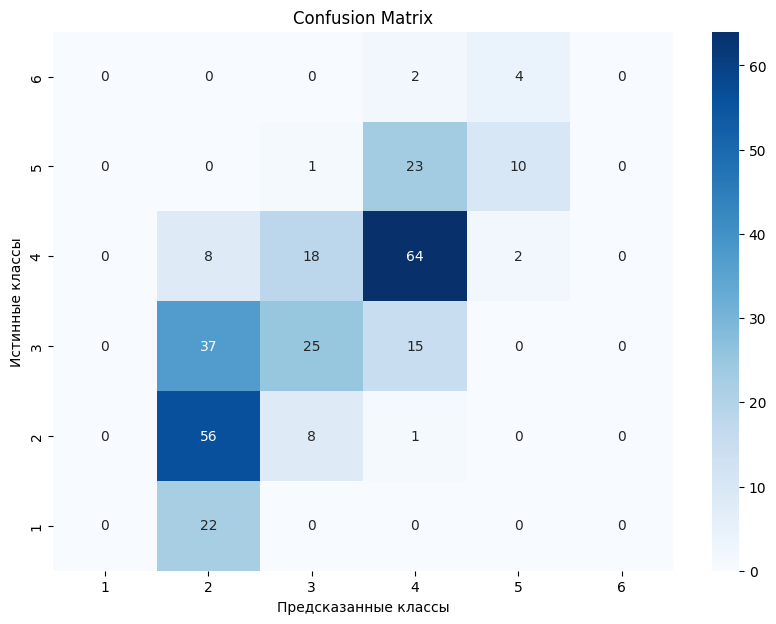

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 56/65 (True Positives / Total Actual Positives)
Precision: 0.46
Recall: 0.86
F1 Score: 0.60

Class: 3
Accuracy: 25/77 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.32
F1 Score: 0.39

Class: 4
Accuracy: 64/92 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.70
F1 Score: 0.65

Class: 5
Accuracy: 10/34 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.29
F1 Score: 0.40

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 7:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.0988091305484922
Validation loss: 1.050931708017985
F1 Score (macro): 0.36612612546670614


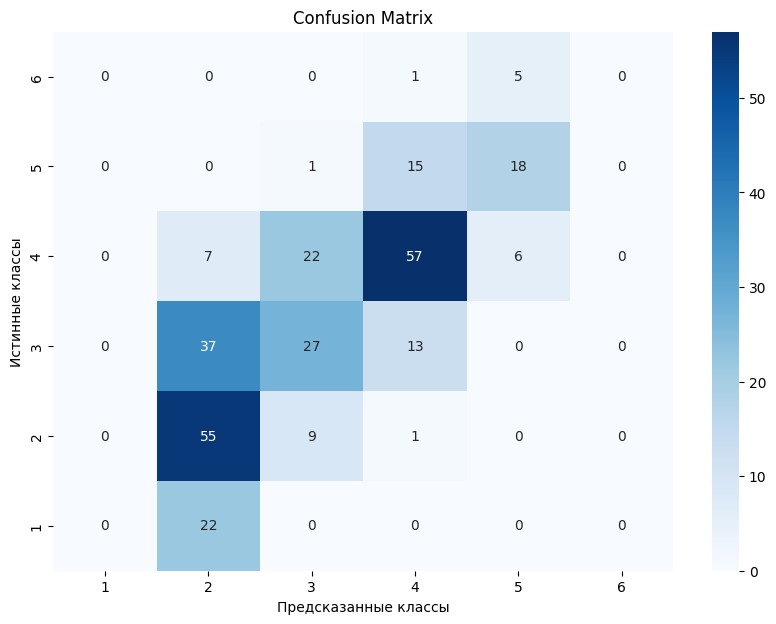

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 55/65 (True Positives / Total Actual Positives)
Precision: 0.45
Recall: 0.85
F1 Score: 0.59

Class: 3
Accuracy: 27/77 (True Positives / Total Actual Positives)
Precision: 0.46
Recall: 0.35
F1 Score: 0.40

Class: 4
Accuracy: 57/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.62
F1 Score: 0.64

Class: 5
Accuracy: 18/34 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.53
F1 Score: 0.57

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 8:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.076929137932034
Validation loss: 0.9745865027109782
F1 Score (macro): 0.4041614720155544


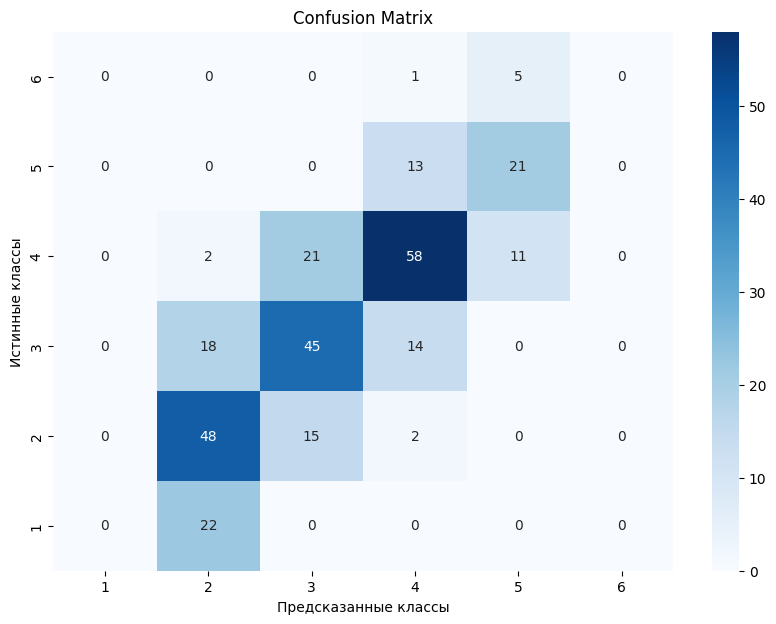

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 48/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.74
F1 Score: 0.62

Class: 3
Accuracy: 45/77 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.58
F1 Score: 0.57

Class: 4
Accuracy: 58/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.63
F1 Score: 0.64

Class: 5
Accuracy: 21/34 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.62
F1 Score: 0.59

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 9:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.0302957699993465
Validation loss: 0.9667480031649271
F1 Score (macro): 0.40441169512060093


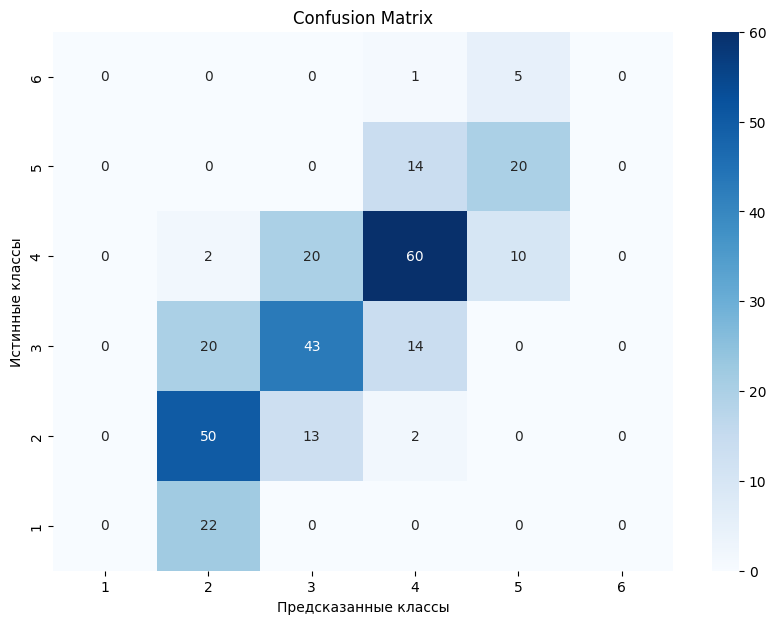

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 50/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.77
F1 Score: 0.63

Class: 3
Accuracy: 43/77 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.56
F1 Score: 0.56

Class: 4
Accuracy: 60/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.65
F1 Score: 0.66

Class: 5
Accuracy: 20/34 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.59
F1 Score: 0.58

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 10:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.9883048548473148
Validation loss: 0.9482797741889953
F1 Score (macro): 0.41657916166310693


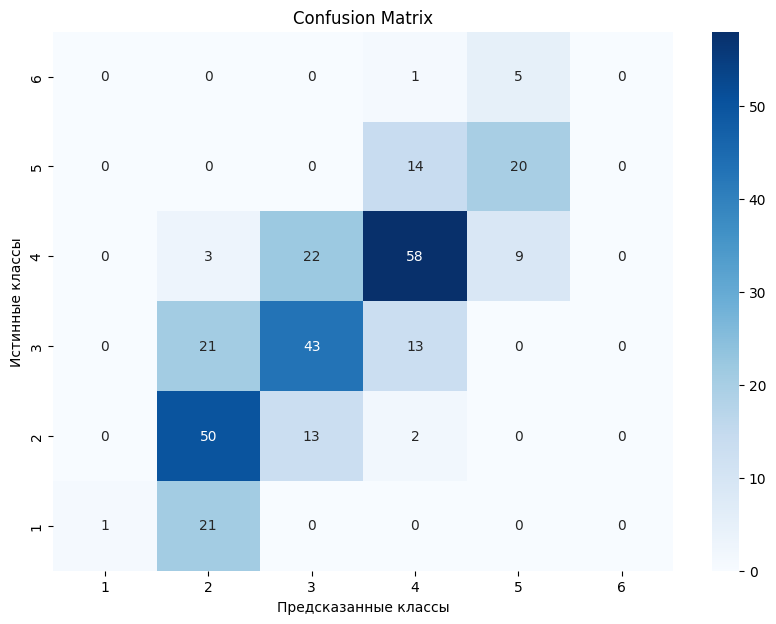

Class: 1
Accuracy: 1/22 (True Positives / Total Actual Positives)
Precision: 1.00
Recall: 0.05
F1 Score: 0.09

Class: 2
Accuracy: 50/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.77
F1 Score: 0.62

Class: 3
Accuracy: 43/77 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.56
F1 Score: 0.55

Class: 4
Accuracy: 58/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.63
F1 Score: 0.64

Class: 5
Accuracy: 20/34 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.59
F1 Score: 0.59

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 11:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.9616990131656016
Validation loss: 0.9502297202746074
F1 Score (macro): 0.47384698634698635


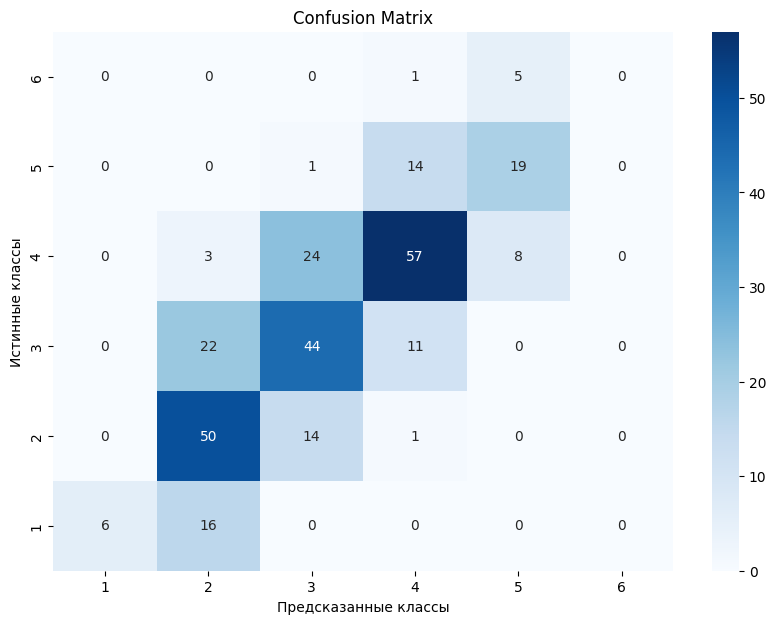

Class: 1
Accuracy: 6/22 (True Positives / Total Actual Positives)
Precision: 1.00
Recall: 0.27
F1 Score: 0.43

Class: 2
Accuracy: 50/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.77
F1 Score: 0.64

Class: 3
Accuracy: 44/77 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.57
F1 Score: 0.55

Class: 4
Accuracy: 57/92 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.62
F1 Score: 0.65

Class: 5
Accuracy: 19/34 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.56
F1 Score: 0.58

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 12:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.9219251312608794
Validation loss: 0.9691574176152548
F1 Score (macro): 0.4972225179620035


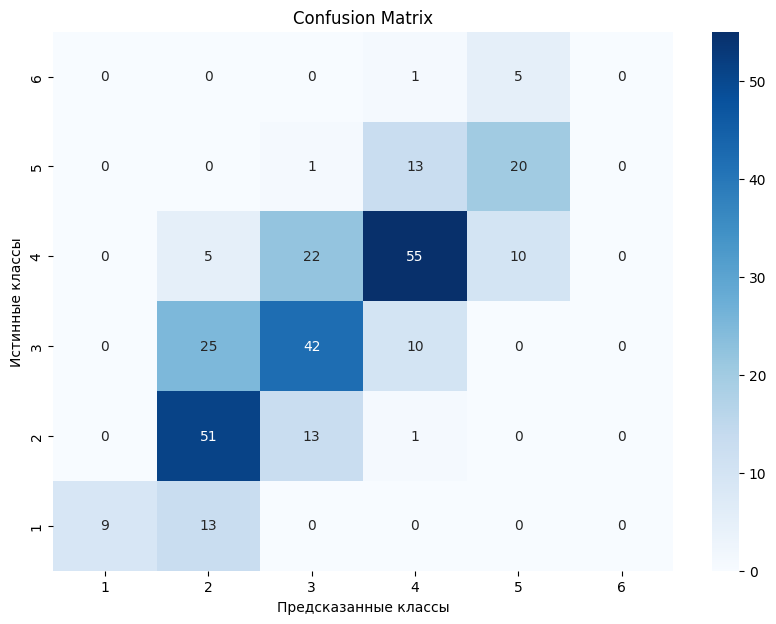

Class: 1
Accuracy: 9/22 (True Positives / Total Actual Positives)
Precision: 1.00
Recall: 0.41
F1 Score: 0.58

Class: 2
Accuracy: 51/65 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.78
F1 Score: 0.64

Class: 3
Accuracy: 42/77 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.55
F1 Score: 0.54

Class: 4
Accuracy: 55/92 (True Positives / Total Actual Positives)
Precision: 0.69
Recall: 0.60
F1 Score: 0.64

Class: 5
Accuracy: 20/34 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.59
F1 Score: 0.58

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 13:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.8875443803982472
Validation loss: 0.9614495118459065
F1 Score (macro): 0.504553467046305


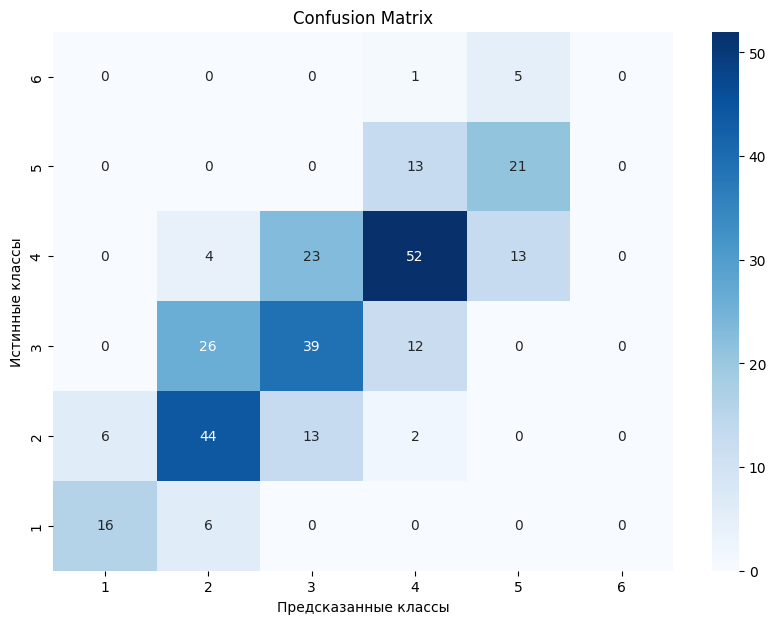

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.73
Recall: 0.73
F1 Score: 0.73

Class: 2
Accuracy: 44/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.68
F1 Score: 0.61

Class: 3
Accuracy: 39/77 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.51
F1 Score: 0.51

Class: 4
Accuracy: 52/92 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.57
F1 Score: 0.60

Class: 5
Accuracy: 21/34 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.62
F1 Score: 0.58

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 14:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.8476470915351327
Validation loss: 0.9565383235613505
F1 Score (macro): 0.5057406650874894


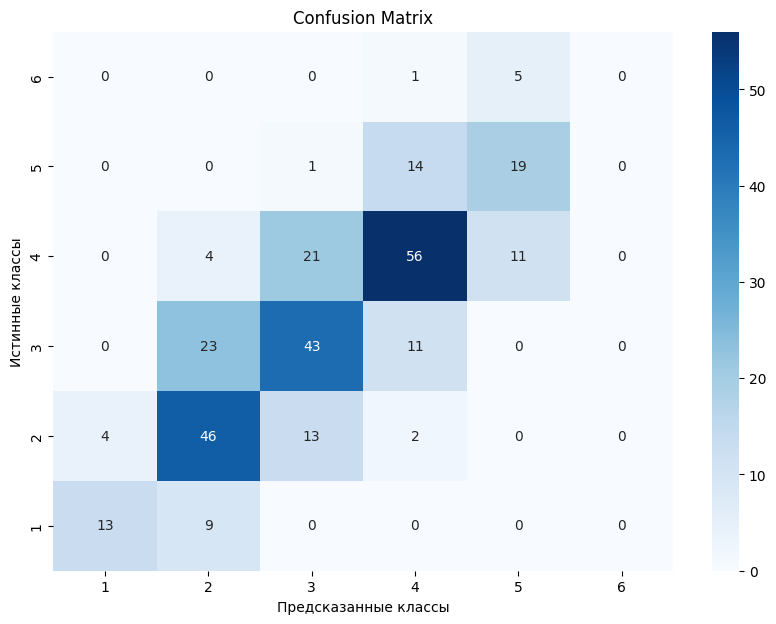

Class: 1
Accuracy: 13/22 (True Positives / Total Actual Positives)
Precision: 0.76
Recall: 0.59
F1 Score: 0.67

Class: 2
Accuracy: 46/65 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.71
F1 Score: 0.63

Class: 3
Accuracy: 43/77 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.56
F1 Score: 0.55

Class: 4
Accuracy: 56/92 (True Positives / Total Actual Positives)
Precision: 0.67
Recall: 0.61
F1 Score: 0.64

Class: 5
Accuracy: 19/34 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.56
F1 Score: 0.55

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 15:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.8412080139625729
Validation loss: 0.9580150286356608
F1 Score (macro): 0.5033357860476495


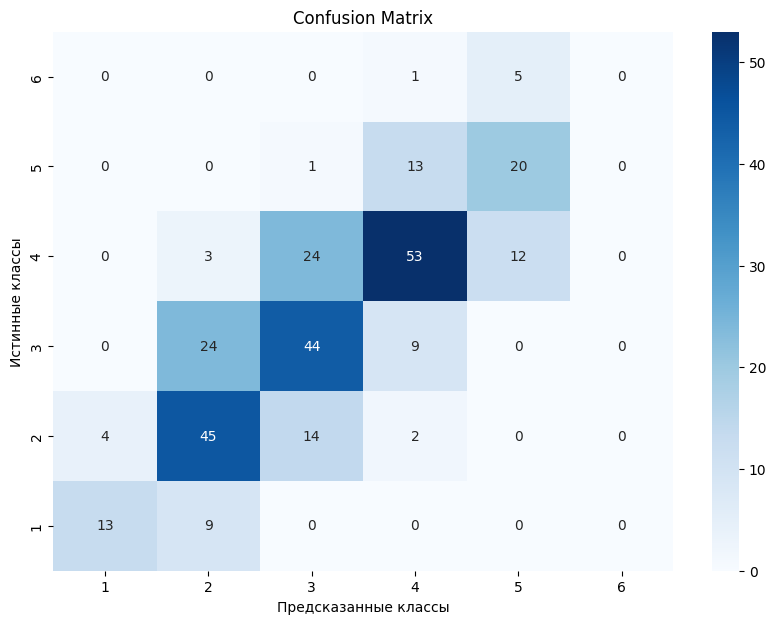

Class: 1
Accuracy: 13/22 (True Positives / Total Actual Positives)
Precision: 0.76
Recall: 0.59
F1 Score: 0.67

Class: 2
Accuracy: 45/65 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.69
F1 Score: 0.62

Class: 3
Accuracy: 44/77 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.57
F1 Score: 0.55

Class: 4
Accuracy: 53/92 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.58
F1 Score: 0.62

Class: 5
Accuracy: 20/34 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.59
F1 Score: 0.56

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 16:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.8085132769242985
Validation loss: 1.0169182419776917
F1 Score (macro): 0.5042462029787881


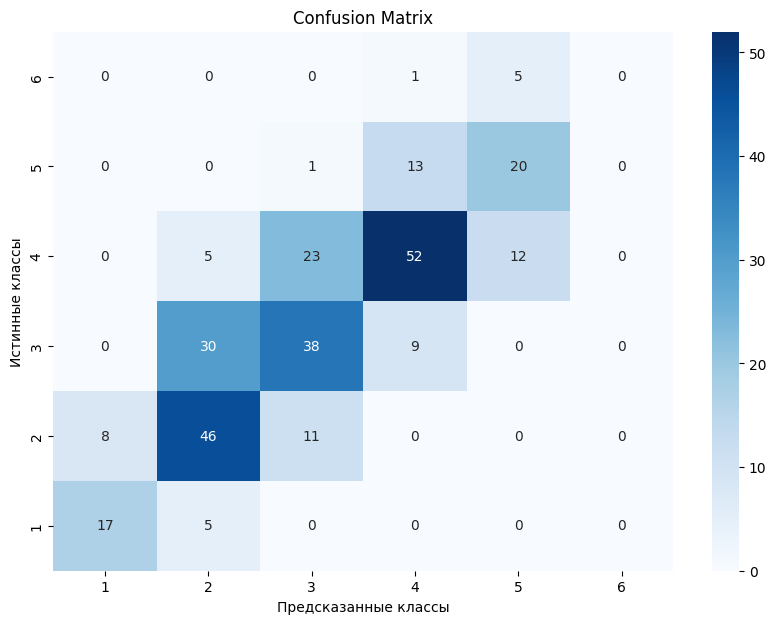

Class: 1
Accuracy: 17/22 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.77
F1 Score: 0.72

Class: 2
Accuracy: 46/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.71
F1 Score: 0.61

Class: 3
Accuracy: 38/77 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.49
F1 Score: 0.51

Class: 4
Accuracy: 52/92 (True Positives / Total Actual Positives)
Precision: 0.69
Recall: 0.57
F1 Score: 0.62

Class: 5
Accuracy: 20/34 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.59
F1 Score: 0.56

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 17:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.7839966768354881
Validation loss: 1.0185998717943827
F1 Score (macro): 0.49521953572276184


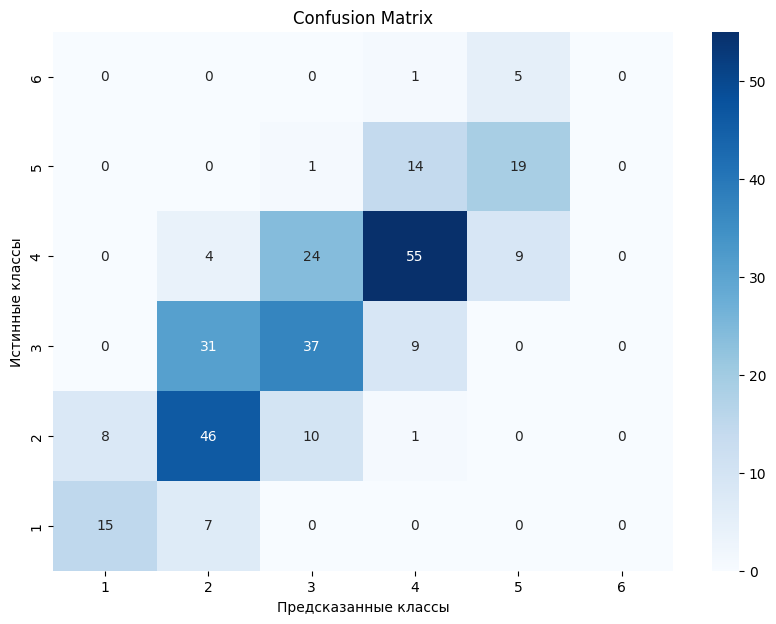

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.68
F1 Score: 0.67

Class: 2
Accuracy: 46/65 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.71
F1 Score: 0.60

Class: 3
Accuracy: 37/77 (True Positives / Total Actual Positives)
Precision: 0.51
Recall: 0.48
F1 Score: 0.50

Class: 4
Accuracy: 55/92 (True Positives / Total Actual Positives)
Precision: 0.69
Recall: 0.60
F1 Score: 0.64

Class: 5
Accuracy: 19/34 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.56
F1 Score: 0.57

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 18:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.7606022146743113
Validation loss: 1.020776359240214
F1 Score (macro): 0.5002726904780569


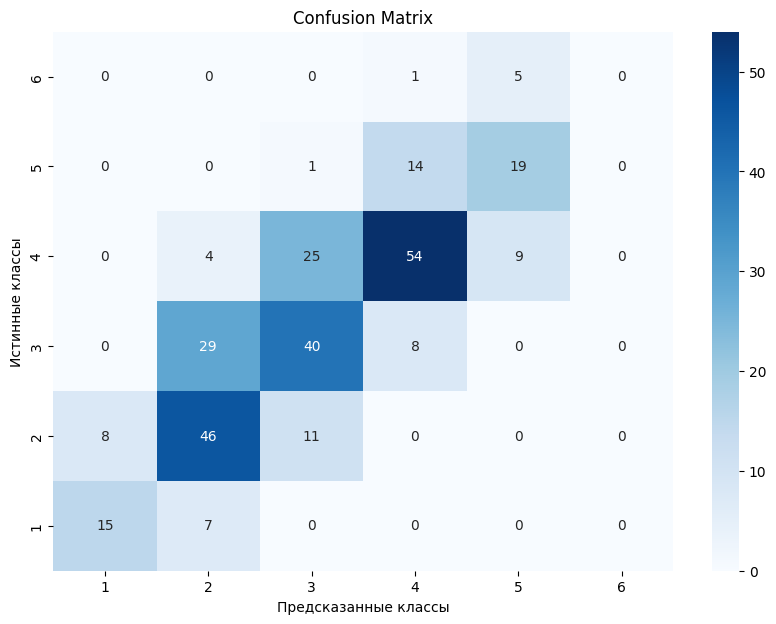

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.68
F1 Score: 0.67

Class: 2
Accuracy: 46/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.71
F1 Score: 0.61

Class: 3
Accuracy: 40/77 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.52
F1 Score: 0.52

Class: 4
Accuracy: 54/92 (True Positives / Total Actual Positives)
Precision: 0.70
Recall: 0.59
F1 Score: 0.64

Class: 5
Accuracy: 19/34 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.56
F1 Score: 0.57

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 19:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.7222527472052988
Validation loss: 0.9965343435605367
F1 Score (macro): 0.5194781418246891


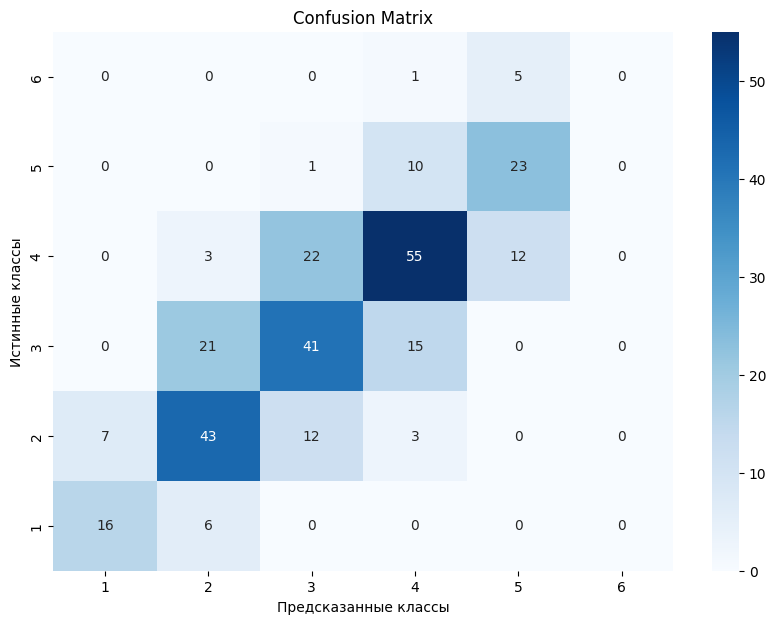

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.70
Recall: 0.73
F1 Score: 0.71

Class: 2
Accuracy: 43/65 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.66
F1 Score: 0.62

Class: 3
Accuracy: 41/77 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.53
F1 Score: 0.54

Class: 4
Accuracy: 55/92 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.60
F1 Score: 0.62

Class: 5
Accuracy: 23/34 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.68
F1 Score: 0.62

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 20:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.6897497543199794
Validation loss: 1.0813368519147237
F1 Score (macro): 0.4875225763810822


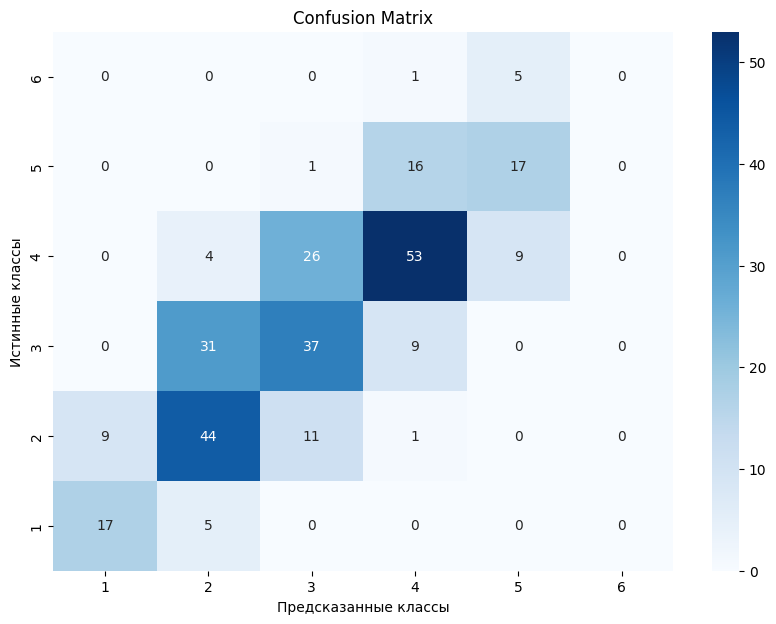

Class: 1
Accuracy: 17/22 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.77
F1 Score: 0.71

Class: 2
Accuracy: 44/65 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.68
F1 Score: 0.59

Class: 3
Accuracy: 37/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.48
F1 Score: 0.49

Class: 4
Accuracy: 53/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.58
F1 Score: 0.62

Class: 5
Accuracy: 17/34 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.50
F1 Score: 0.52

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 21:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.6752018108377307
Validation loss: 1.085396941502889
F1 Score (macro): 0.5005681949452251


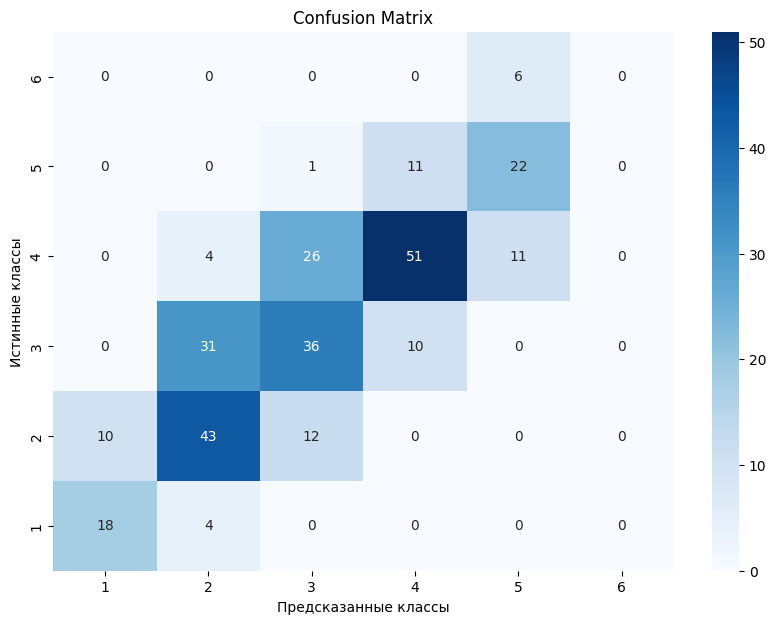

Class: 1
Accuracy: 18/22 (True Positives / Total Actual Positives)
Precision: 0.64
Recall: 0.82
F1 Score: 0.72

Class: 2
Accuracy: 43/65 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.66
F1 Score: 0.59

Class: 3
Accuracy: 36/77 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.47
F1 Score: 0.47

Class: 4
Accuracy: 51/92 (True Positives / Total Actual Positives)
Precision: 0.71
Recall: 0.55
F1 Score: 0.62

Class: 5
Accuracy: 22/34 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.65
F1 Score: 0.60

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 22:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.636887422462148
Validation loss: 1.0359673659006754
F1 Score (macro): 0.5005918877701906


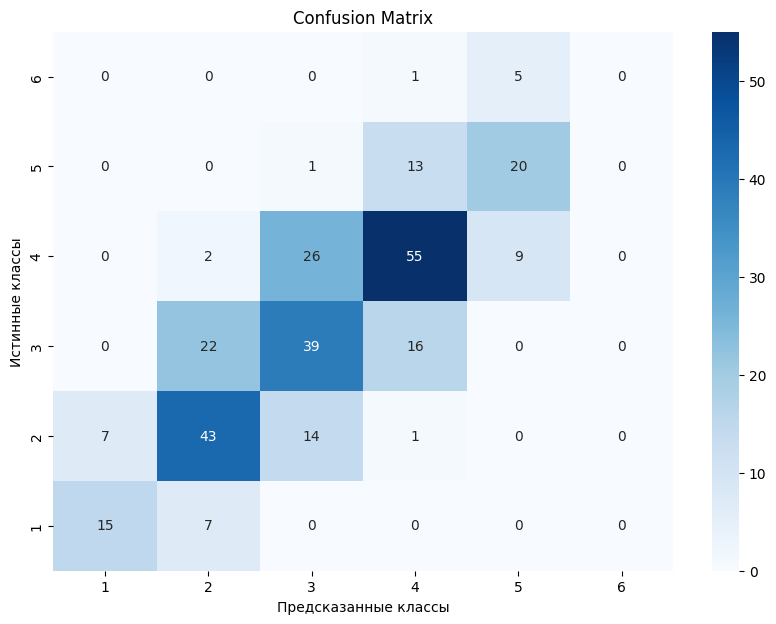

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.68
F1 Score: 0.68

Class: 2
Accuracy: 43/65 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.66
F1 Score: 0.62

Class: 3
Accuracy: 39/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.51
F1 Score: 0.50

Class: 4
Accuracy: 55/92 (True Positives / Total Actual Positives)
Precision: 0.64
Recall: 0.60
F1 Score: 0.62

Class: 5
Accuracy: 20/34 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.59
F1 Score: 0.59

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 23:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.6305309388581224
Validation loss: 1.0648978153864543
F1 Score (macro): 0.5146337121673602


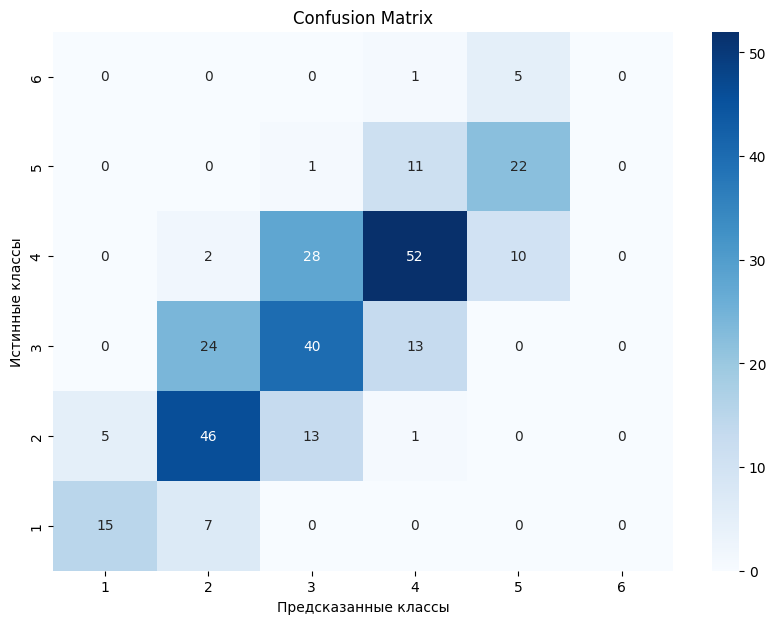

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.75
Recall: 0.68
F1 Score: 0.71

Class: 2
Accuracy: 46/65 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.71
F1 Score: 0.64

Class: 3
Accuracy: 40/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.52
F1 Score: 0.50

Class: 4
Accuracy: 52/92 (True Positives / Total Actual Positives)
Precision: 0.67
Recall: 0.57
F1 Score: 0.61

Class: 5
Accuracy: 22/34 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.65
F1 Score: 0.62

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 24:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.6015784233573853
Validation loss: 1.1799088398615518
F1 Score (macro): 0.48219000636069226


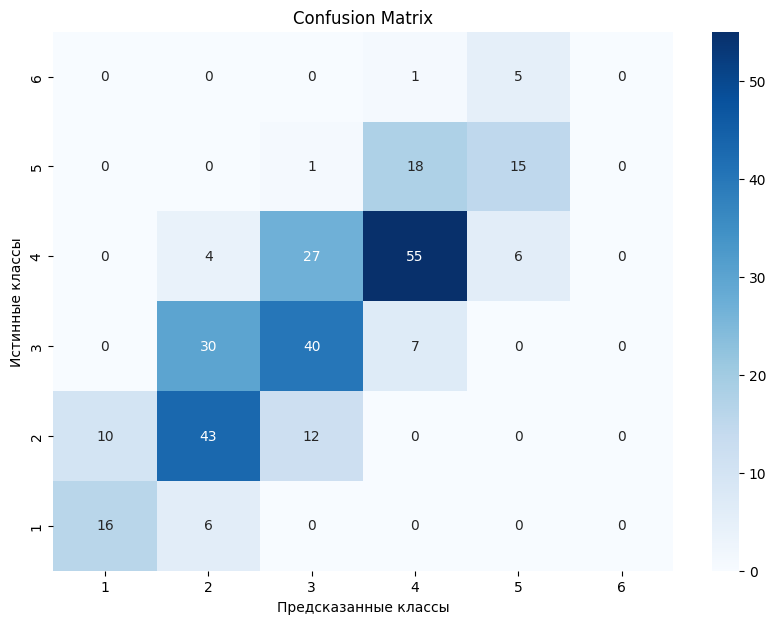

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.73
F1 Score: 0.67

Class: 2
Accuracy: 43/65 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.66
F1 Score: 0.58

Class: 3
Accuracy: 40/77 (True Positives / Total Actual Positives)
Precision: 0.50
Recall: 0.52
F1 Score: 0.51

Class: 4
Accuracy: 55/92 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.60
F1 Score: 0.64

Class: 5
Accuracy: 15/34 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.44
F1 Score: 0.50

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 25:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.5853253678074033
Validation loss: 1.1424029231071473
F1 Score (macro): 0.490205840635996


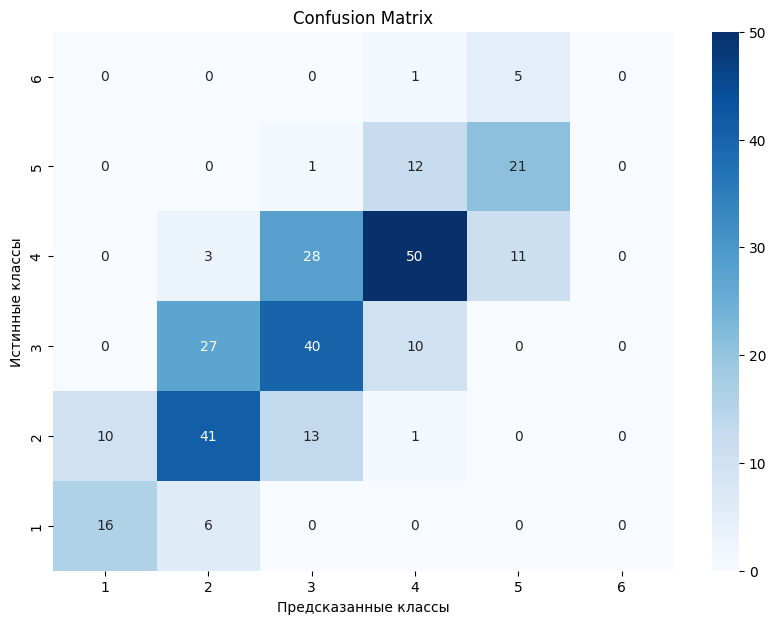

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.73
F1 Score: 0.67

Class: 2
Accuracy: 41/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.63
F1 Score: 0.58

Class: 3
Accuracy: 40/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.52
F1 Score: 0.50

Class: 4
Accuracy: 50/92 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.54
F1 Score: 0.60

Class: 5
Accuracy: 21/34 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.62
F1 Score: 0.59

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 26:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.5619813037200236
Validation loss: 1.140183957417806
F1 Score (macro): 0.4923292709705754


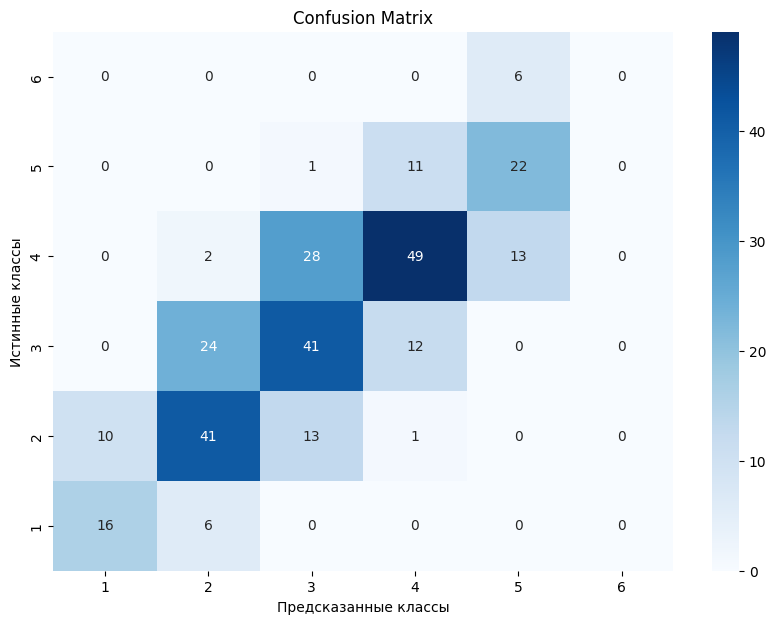

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.73
F1 Score: 0.67

Class: 2
Accuracy: 41/65 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.63
F1 Score: 0.59

Class: 3
Accuracy: 41/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.53
F1 Score: 0.51

Class: 4
Accuracy: 49/92 (True Positives / Total Actual Positives)
Precision: 0.67
Recall: 0.53
F1 Score: 0.59

Class: 5
Accuracy: 22/34 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.65
F1 Score: 0.59

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 27:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.5476384097196925
Validation loss: 1.219437011082967
F1 Score (macro): 0.4857422534447496


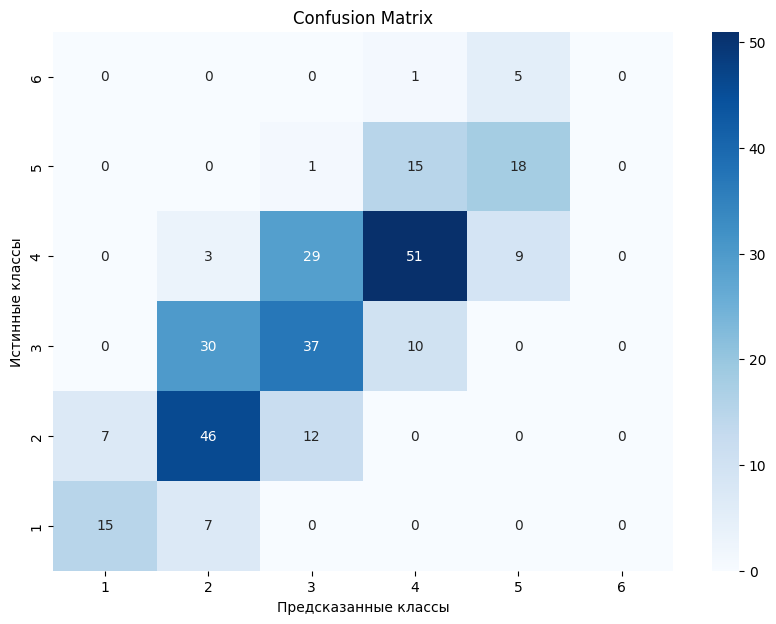

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.68
F1 Score: 0.68

Class: 2
Accuracy: 46/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.71
F1 Score: 0.61

Class: 3
Accuracy: 37/77 (True Positives / Total Actual Positives)
Precision: 0.47
Recall: 0.48
F1 Score: 0.47

Class: 4
Accuracy: 51/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.55
F1 Score: 0.60

Class: 5
Accuracy: 18/34 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.53
F1 Score: 0.55

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 28:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.5138294619368756
Validation loss: 1.16420156955719
F1 Score (macro): 0.4948379322258772


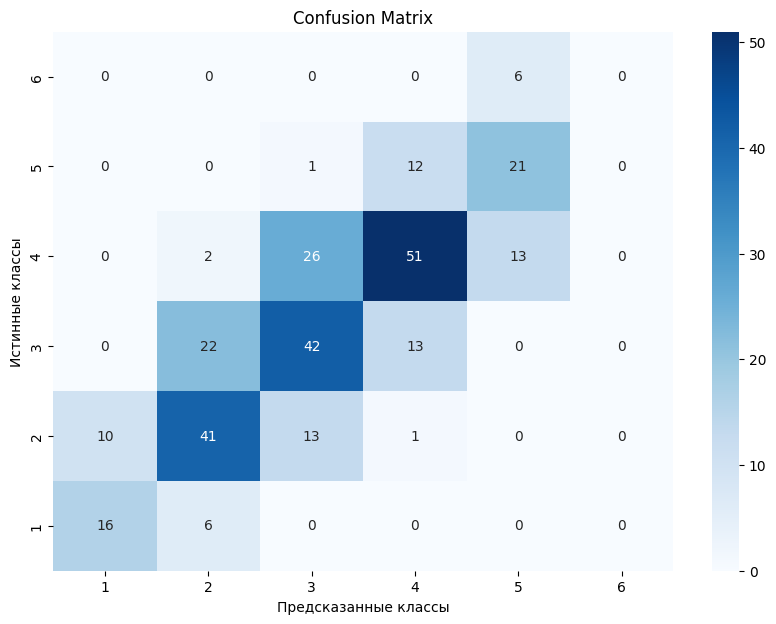

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.73
F1 Score: 0.67

Class: 2
Accuracy: 41/65 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.63
F1 Score: 0.60

Class: 3
Accuracy: 42/77 (True Positives / Total Actual Positives)
Precision: 0.51
Recall: 0.55
F1 Score: 0.53

Class: 4
Accuracy: 51/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.55
F1 Score: 0.60

Class: 5
Accuracy: 21/34 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.62
F1 Score: 0.57

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 29:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.5270513533137915
Validation loss: 1.2108025550842285
F1 Score (macro): 0.48795537766472563


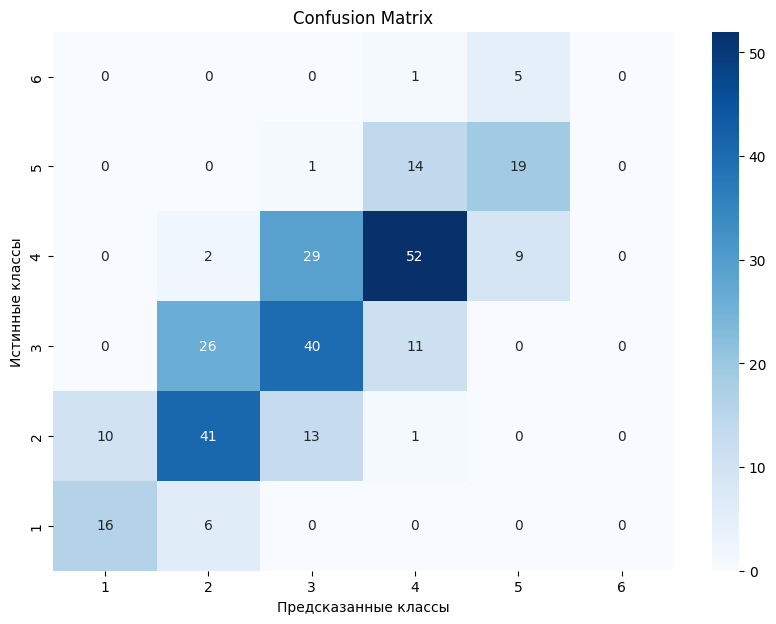

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.73
F1 Score: 0.67

Class: 2
Accuracy: 41/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.63
F1 Score: 0.59

Class: 3
Accuracy: 40/77 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.52
F1 Score: 0.50

Class: 4
Accuracy: 52/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.57
F1 Score: 0.61

Class: 5
Accuracy: 19/34 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.56
F1 Score: 0.57

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 30:   0%|          | 0/127 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = 'cuda'

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

max_f1 = 0

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (macro): {val_f1}')
    #accuracy_per_class(predictions, true_vals)
    plot_confusion_matrix(predictions, true_vals, label_dict)
    metrics_per_class(predictions, true_vals, label_dict)

    if val_f1 > max_f1:
        max_f1 = val_f1
        model.save_pretrained(f"/content/ReadMe_{language}_roberta")